# Inputs

In [1]:


import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
import sys
import os
import time
import scipy
import scipy.io as scio
from scipy.optimize import curve_fit


from LCLSDataToolsNew.GeneralTools import *
from LCLSDataToolsNew.filterTools import *
from LCLSDataToolsNew.diffSignalTools import *
from LCLSDataToolsNew.binningToolsErr import *
from LCLSDataToolsNew.anisotropyToolsAll import *
from LCLSDataToolsNew.SVDTools import *
from LCLSDataToolsNew.SetUpFns import *
from LCLSDataToolsNew.DiffBinFns import *
from LCLSDataToolsNew.ReduceFns import *
from LCLSDataToolsNew.StackFns import *
from LCLSDataToolsNew.IRFtools import *
from LCLSDataToolsNew.plottingTools import *
from LCLSDataToolsNew.ebeamTools import *


print('Import Complete!')

exper = 'xcs101332324'

### s3df ###
smalldata_folder='/sdf/data/lcls/ds/xcs/'+exper+'/hdf5/smalldata/'

## set output path as desired
outpath='/sdf/data/lcls/ds/xcs/'+exper+'/results/ReducedData/' 


# # #make directories if needed 
# if os.path.isdir(outpath+'/figures/')==False:
#     os.makedirs(outpath+'/figures/')
# if os.path.isdir(outpath+'/npy/')==False:
#     os.makedirs(outpath+'/npy/')


Import Complete!


# set up VarDict

In [2]:
varDict = {
        'ipm4'          : 'ipm4/sum',
        'ipm5'          : 'ipm5/sum',
        'xray_status'   : 'lightStatus/xray',
        'laser_status'  : 'lightStatus/laser',
        'ebeam_hv'      : 'ebeam/photon_energy',
        'scan_vec'      : 'scan/var0',
        'laser_diode'   : '/diodeGon/channels/',
    
        ## tt variables
        'ttCorr'        : 'tt/ttCorr',
        'ttAMPL'        : 'tt/AMPL',
        'ttFWHM'        : 'tt/FLTPOSFWHM',
        'ttFLTPOS'      : 'tt/FLTPOS',
        # 'ttFLTPOS_PS'   : 'tt/FLTPOS_PS', ## in picoseconds
        'encoder'       : 'enc/lasDelay',
        'lxt'           : 'epics/lxt' , 
        # 'lxt_ttc'       : 'epics/lxt_ttc',
        
        ## scattering variables
        'azav'      : 'epix10k2M/azav_azav',
        'qs'        : 'UserDataCfg/epix10k2M/azav__azav_q',
        'phis'      :  'UserDataCfg/epix10k2M/azav__azav_phiVec',
    
        ## scattering detector error
        #'azav_sqr'     :  'epix10k2M/azav_azav_square',
        # 'pix_per_azav'  :  'UserDataCfg/epix10k2M/azav__azav_norm',


        ## for rescaling q axis per energy
        'set_ebeam_keV' : 'UserDataCfg/epix10k2M/azav__azav_eBeam',
        'set_d2sam_cm'  : 'UserDataCfg/epix10k2M/azav__azav_dis_to_sam'

        }

# set up ParamDict

In [3]:
setbins=np.arange(-0.25e-12,.5e-12,.01e-12)



paramDict1= {
        'binSetup'  : 'points',
        'binSet2'   : 300,
        'binMethod' : 'ave', 
    
        'qnorm'     : (.3,2.5), 
        'qrange'    : (0.5,2.5),
        'show_filters'  : True, #show filter plots
        'useAzav_std'  : False, 
        'azav_percent_filter' : None, 
                    
        'ipm'    : 5, # select ipm to use for I0
    
        'corr_filter' : False,
        'corr_threshold': .01 , 
        'slope_filter': False, 
        'slope_param': (10/1e4,0), #slope,intercept
    
        'ipm_filter' : (10,None), #set limits for ipm intensity
        'Iscat_threshold'  : 0, #lower limit for Iscat

        'use_TT'   :  True,  
        'scan_var' : None,
        'x_var'   : None,

        't0_corr' : None,  #false or float offset for time zero
        'enforce_iso': False, #enforce isotropic off shots?
        'energy_corr' : True, # ebeam photon energy correction
        'NonLin_corr': 'SVDbyBin', #None, SVD, poly, or SVDbyBin

        'AdjSub'    : 50, #number of adjascent off shots to average and subtract, -1 subtracts all
        'aniso'  : True,
        'shift_deg' :30,
        'xstat' : True,

        'BackSub': None,
        'earlytrange':(-0.5e-12,0e-12),

        'showSVD': False, #do svd
        'SVD_n': 4, # number of svd components
        'slice_plot': None, #how to slice up plots displayed at end
        'smooth':None, #smoothing before svd?

        'overwrite' : True, # overwrite files? 
        'save_mat'  : False,
        'save_h5' : True,
        

    }

# ReduceData Step By Step

## set up

In [4]:

run=214
inDir=smalldata_folder
outDir=outpath

plt.close('all')
fname=inDir+exper+'_Run%04i.h5'%run
paramDict=paramDict1.copy()
outDict={}

## loadH5 file, make h5 dictionary in outDict
h5Dict only has variables from varDict

In [5]:

LoadH5(fname,outDir,varDict,paramDict, outDict)
outDict['h5Dict'].keys()

basename is  xcs101332324_Run0214
key not found scan_vec
key not found laser_diode
scan variable is  newdelay
finished loading h5


dict_keys(['ipm4', 'ipm5', 'xray_status', 'laser_status', 'ebeam_hv', 'ttCorr', 'ttAMPL', 'ttFWHM', 'ttFLTPOS', 'encoder', 'lxt', 'azav', 'qs', 'phis', 'set_ebeam_keV', 'set_d2sam_cm', 'scan_vec'])

## Optional: Offset azav if needed

In [6]:
# NegativeCountsOffset(outDict)

negative values in azav!
offsetting by -28.757807626924293


## optional - MaskAzav masks specific azimuthal bins


In [9]:
# MaskAzav(paramDict,outDict,listBinInd=np.array([[0,0],[6,425],[6,400],[6,401]]))

## Filters

In [10]:
# calculate Iscat and set up laser on, x-ray on filters

setupFilters(paramDict,outDict)


calculated Iscat
setupFilters - done!


filters with Iscat include thresholds on ipm and Iscat as well as correlation or slop filter

### Iscat Filters

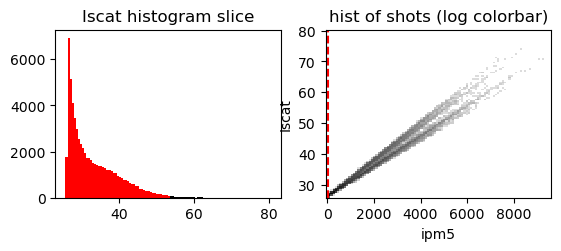

In [11]:
IscatFilters(paramDict,outDict)


### optional - eBeam X-ray photon energy filter

In [12]:
# eBeamFilter(paramDict,outDict)

### filter on time tool parameters

Note: there are hardcoded thresholds for parameters in addition to histogram filter

TTAMP: fraction_kept  0.999000594241262  lower  0.002000419896221591  upper  0.6594312066753524
TTFWHM: fraction_kept  0.9910033248582045  lower  70.006854747938  upper  143.52859737520157
TTPOS: fraction_kept  0.9901680082113338  lower  172.65610615950172  upper  874.2659333298222


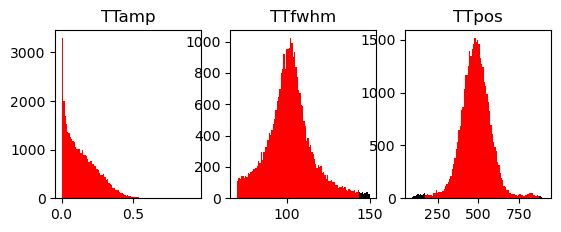

In [13]:
if paramDict['use_TT'] is not False:
    TTfilter(paramDict,outDict)

### save figure of filter parameters

In [14]:
# saveReduction(outDir,paramDict,outDict)

### optional -  Enforce isotropic off shots

In [15]:

if paramDict['enforce_iso']:
    EnforceIso(paramDict,outDict)

## make axis for scan variable, include TT and other delays

In [16]:
MakeScanAx(paramDict,outDict,tt_corrNew=None)

t=(encoder + tt/ttCorr)*1e-12


## subtract X-ray dark shots

In [17]:
# DarkSubtract(paramDict,outDict)

## Normalization of data

normalize data
(117,) (66059, 11, 117)
normalize data done!
normalization applied


/sdf/home/s/slraj/code/ScatteringCode/ReduceScatt-main/LCLSDataToolsNew/DiffBinFns.py:152: RuntimeWarning: Mean of empty slice
  cake=np.nanmean(divAny(cspad_azav[early_x,:,:],normal_factor[early_x,:]),0) #normalize by norm
/sdf/home/s/slraj/code/ScatteringCode/ReduceScatt-main/LCLSDataToolsNew/DiffBinFns.py:158: RuntimeWarning: Mean of empty slice
  outDict['loff_cake']=np.nanmean(cspad_azav[early_x,:,:],0)


Text(0.5, 0.98, 'average laser off cake for each phi slice')

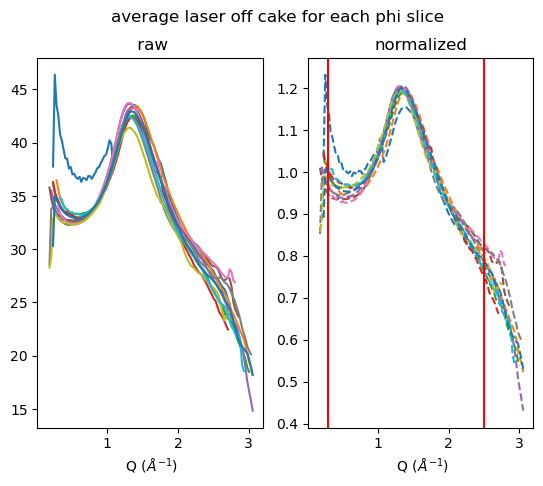

In [18]:
NormalFactor(paramDict,outDict)

plt.figure()
plt.subplot(1,2,1)
plt.plot(outDict['h5Dict']['qs'],outDict['loff_cake'].T)
plt.title(' raw')
plt.xlabel(' Q ($\AA^{-1}$) ')
plt.subplot(1,2,2)
plt.plot(outDict['h5Dict']['qs'],outDict['loff_cake_norm'].T,'--')
plt.axvline(paramDict['qnorm'][0],color='r')
plt.axvline(paramDict['qnorm'][1],color='r')
plt.title('normalized')
plt.xlabel(' Q ($\AA^{-1}$) ')
plt.suptitle('average laser off cake for each phi slice')

## X-ray photon energy correction

applying energy correction


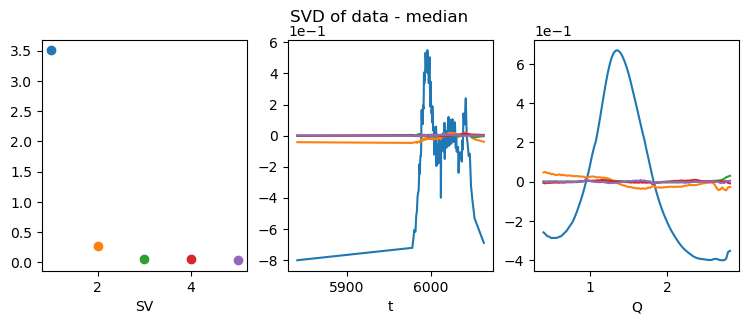

In [19]:
if paramDict['energy_corr']:
    EnergyCorr(paramDict,outDict)

## X-ray intensity detector nonlinearity corrections

do SVD nonlinear corrections for each phi bin
nonlinear correction - done!


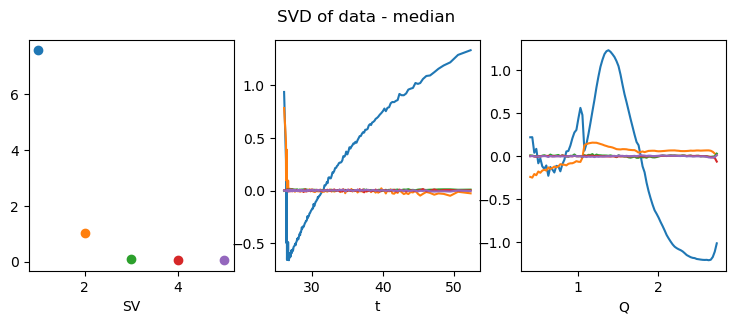

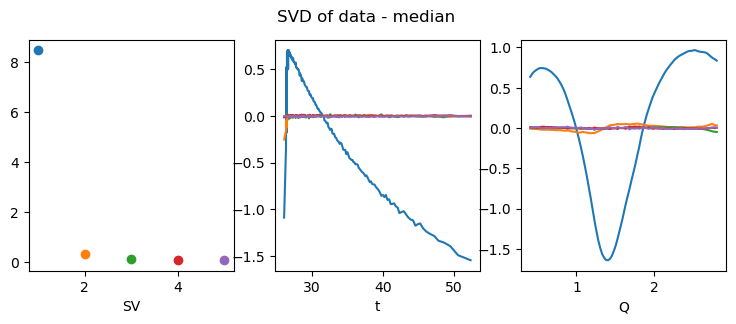

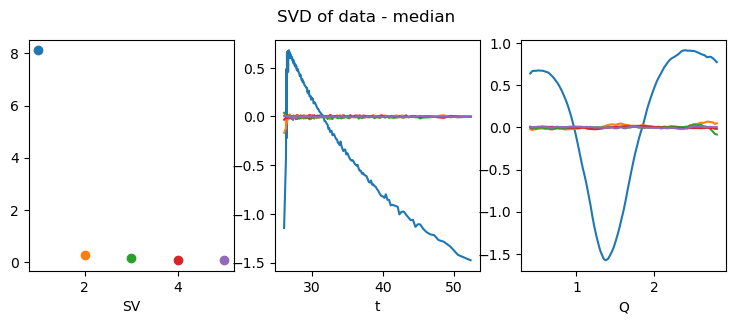

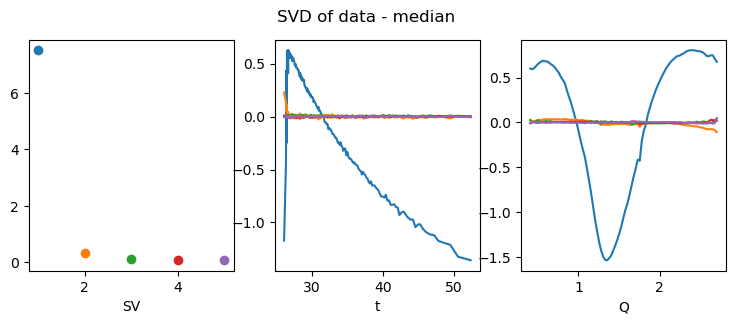

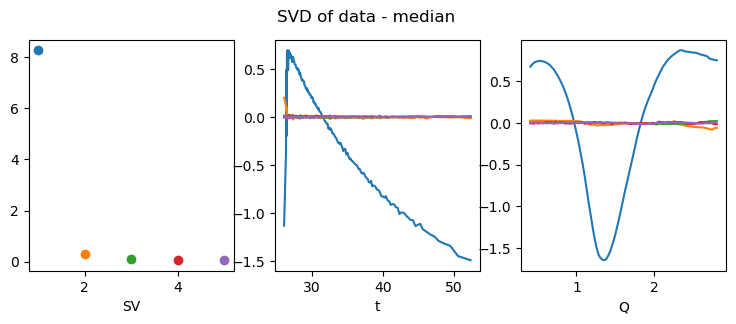

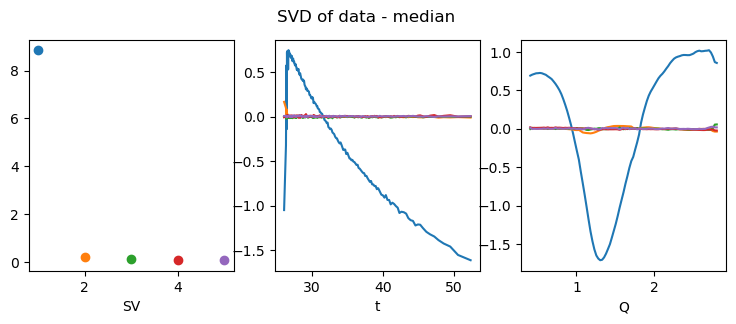

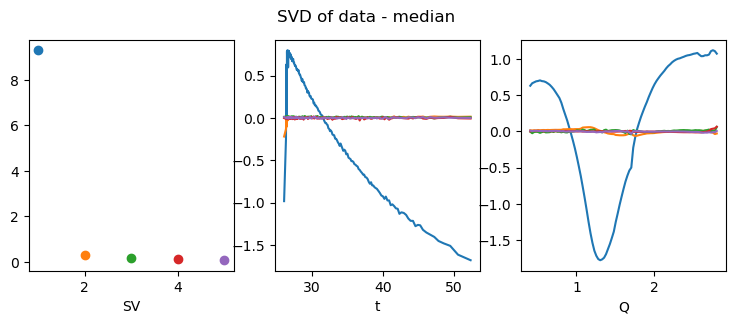

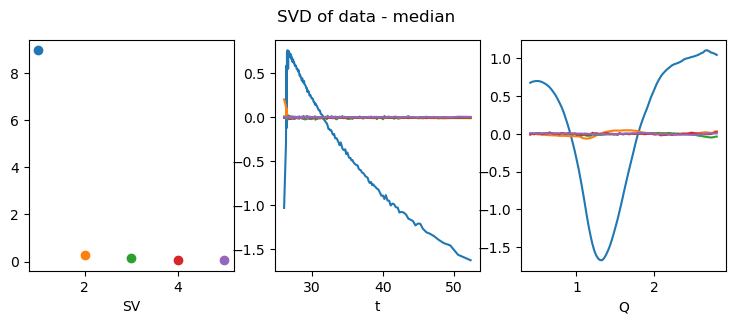

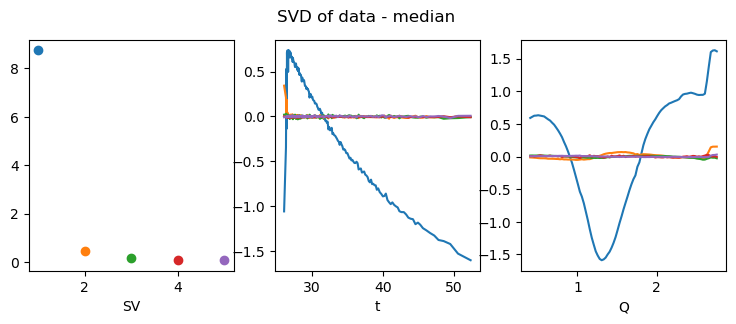

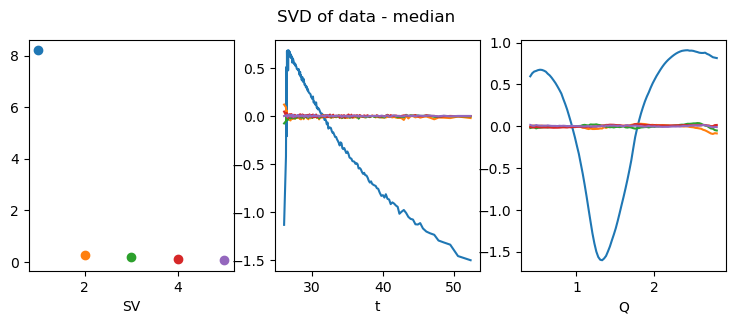

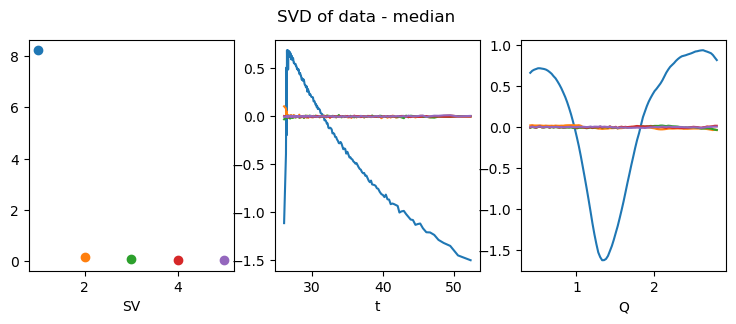

In [20]:
if paramDict['NonLin_corr'] is not None:
    DetectorNonlinCorr(paramDict,outDict)

## make difference signal

starting difference signal
Difference Signal Done!


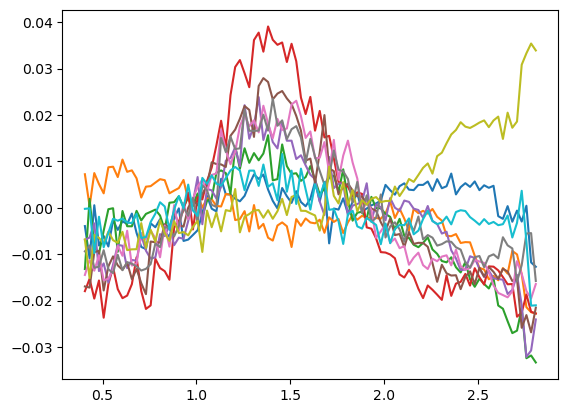

In [21]:
doDifference(paramDict,outDict)

plt.plot(outDict['h5Dict']['qs'],np.nanmean(outDict['diff_Data'][100:110,:,:],1).T)

## do scan variable binning

In [22]:
doTimeBinning(paramDict,outDict)

Starting binning
bin by points, 300 per bin
dict_keys(['xcenter', 'xmean', 'xstd', 'bincount', 'binmean', 'binstd'])
binning - done!


## optional - early time background subtraction

In [23]:
if paramDict['BackSub']=='SVD':
    doSVDBackSub(paramDict,outDict,earlytrange=paramDict['earlytrange'])
elif paramDict['BackSub']=='ave':
    AveBackSub(paramDict,outDict,earlytrange=paramDict['earlytrange'])

## optional - do anisotropy S0 S2 decomposition

In [24]:
print(outDict['h5Dict']['phis'])
if paramDict['aniso']:
    doAnisotropy(paramDict,outDict)


[4.11512233e-06 5.71201939e-01 1.14239976e+00 1.71359759e+00
 2.28479541e+00 2.85599324e+00 3.42719106e+00 3.99838889e+00
 4.56958671e+00 5.14078453e+00 5.71198236e+00 6.28318018e+00]
start anisotropy
shift is 30 degrees
101


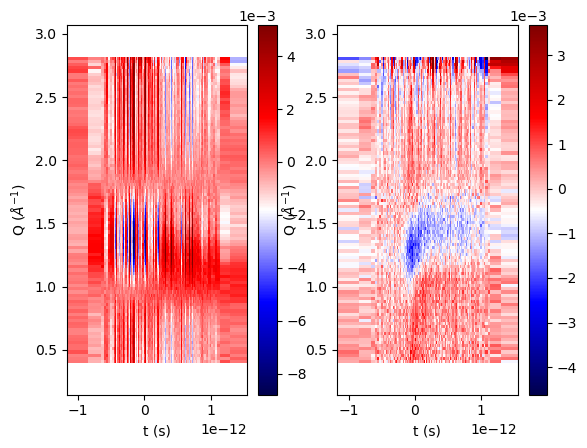

In [25]:
plot_2d(outDict['xcenter'],outDict['h5Dict']['qs'],outDict['S0'],ccmap='seismic',fig='aniso',sub=(1,2,1))
plot_2d(outDict['xcenter'],outDict['h5Dict']['qs'],outDict['S2'],ccmap='seismic',fig='aniso',sub=(1,2,2))

## save dictionary to npy file and h5/mat if desired

In [26]:
# saveDictionary(outDir+'npy/',paramDict,outDict)

## make nice overview plot and save figure

In [27]:
# overviewPlot(outDir+'figures/',paramDict,outDict)